In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

sns.set(style="whitegrid")

BASE = Path("..") / "data" / "processed"
df = pd.read_csv(BASE / "combined_state_summary_2022.csv")

df.head()


,StateFIPS,State,Abbrev,obesity_rate,smoking_rate,incidence_rate_adj,incidence_cases
0,1,Alabama,AL,35.703,14.895,40.9,2568.0
1,2,Alaska,AK,28.789,14.699,40.8,306.0
2,4,Arizona,AZ,29.385,11.471,31.9,2945.0
3,5,Arkansas,AR,32.196,16.560,41.5,1541.0
4,6,California,CA,23.565,8.590,34.4,15465.0


In [2]:
lin_model = smf.ols(
    formula="incidence_rate_adj ~ obesity_rate + smoking_rate",
    data=df
).fit()

print(lin_model.summary())


                            OLS Regression Results                            
Dep. Variable:     incidence_rate_adj   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     20.26
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           4.17e-07
Time:                        22:43:54   Log-Likelihood:                -125.31
No. Observations:                  51   AIC:                             256.6
Df Residuals:                      48   BIC:                             262.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.6484      3.236      6.072   

In [3]:
lin_results = {
    "coef_obesity": lin_model.params["obesity_rate"],
    "p_obesity": lin_model.pvalues["obesity_rate"],
    "coef_smoking": lin_model.params["smoking_rate"],
    "p_smoking": lin_model.pvalues["smoking_rate"],
    "intercept": lin_model.params["Intercept"],
    "r2": lin_model.rsquared,
    "r2_adj": lin_model.rsquared_adj,
}

lin_results


{'coef_obesity': np.float64(0.39803762072801635),
 'p_obesity': np.float64(0.021348133700493974),
 'coef_smoking': np.float64(0.42628226529119384),
 'p_smoking': np.float64(0.08462726398423072),
 'intercept': np.float64(19.648415249313544),
 'r2': np.float64(0.45777425017093454),
 'r2_adj': np.float64(0.43518151059472343)}

In [4]:
X = df[["obesity_rate", "smoking_rate"]]
y = df["incidence_rate_adj"]

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X, y)
rf_pred = rf.predict(X)
rf_r2 = r2_score(y, rf_pred)

rf_importances = pd.Series(rf.feature_importances_, index=X.columns)
rf_r2, rf_importances


(0.89305179875803,
 obesity_rate    0.604324
 smoking_rate    0.395676
 dtype: float64)

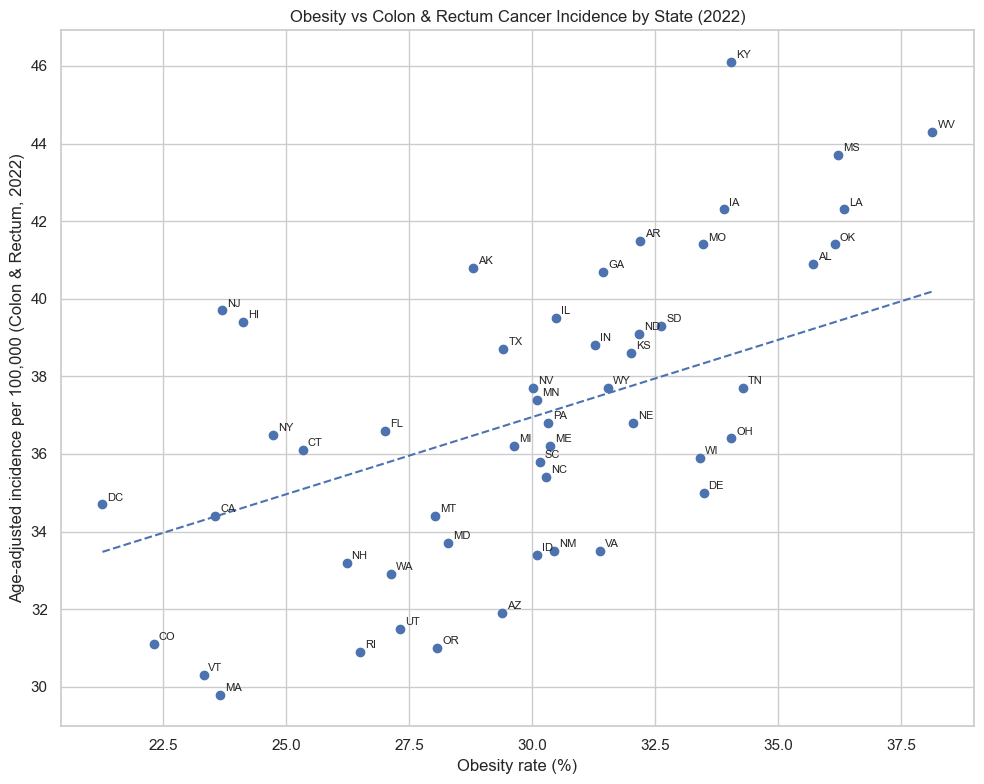

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(df["obesity_rate"], df["incidence_rate_adj"])

for _, row in df.iterrows():
    plt.text(
        row["obesity_rate"] + 0.1,
        row["incidence_rate_adj"] + 0.1,
        row["Abbrev"],
        fontsize=8
    )

# Add a simple regression line using the linear model
x_vals = np.linspace(df["obesity_rate"].min(), df["obesity_rate"].max(), 100)
y_vals = (lin_model.params["Intercept"]
          + lin_model.params["obesity_rate"] * x_vals
          + lin_model.params["smoking_rate"] * df["smoking_rate"].mean())

plt.plot(x_vals, y_vals, linestyle="--")

plt.xlabel("Obesity rate (%)")
plt.ylabel("Age-adjusted incidence per 100,000 (Colon & Rectum, 2022)")
plt.title("Obesity vs Colon & Rectum Cancer Incidence by State (2022)")
plt.tight_layout()
plt.show()


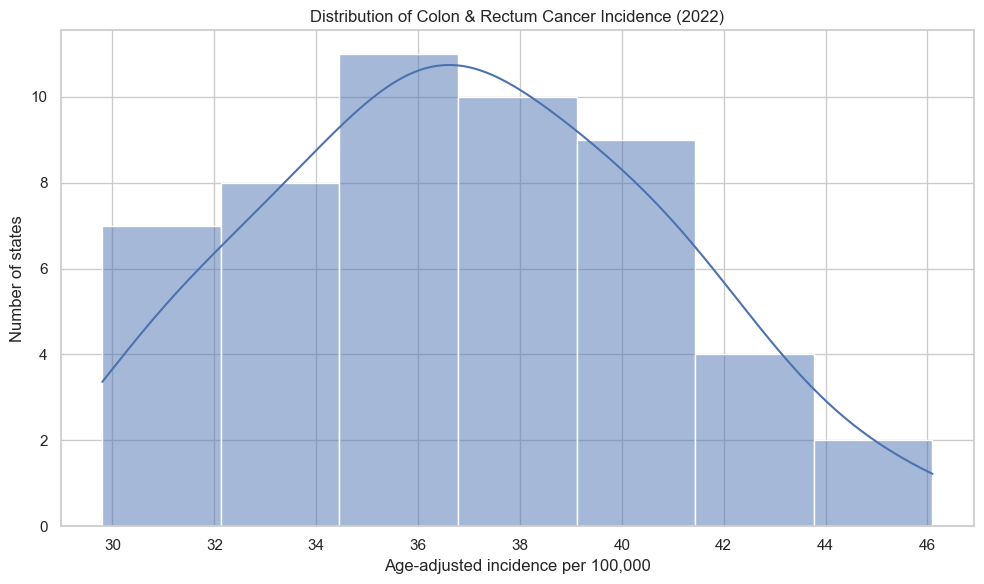

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(df["incidence_rate_adj"], kde=True)
plt.xlabel("Age-adjusted incidence per 100,000")
plt.ylabel("Number of states")
plt.title("Distribution of Colon & Rectum Cancer Incidence (2022)")
plt.tight_layout()
plt.show()


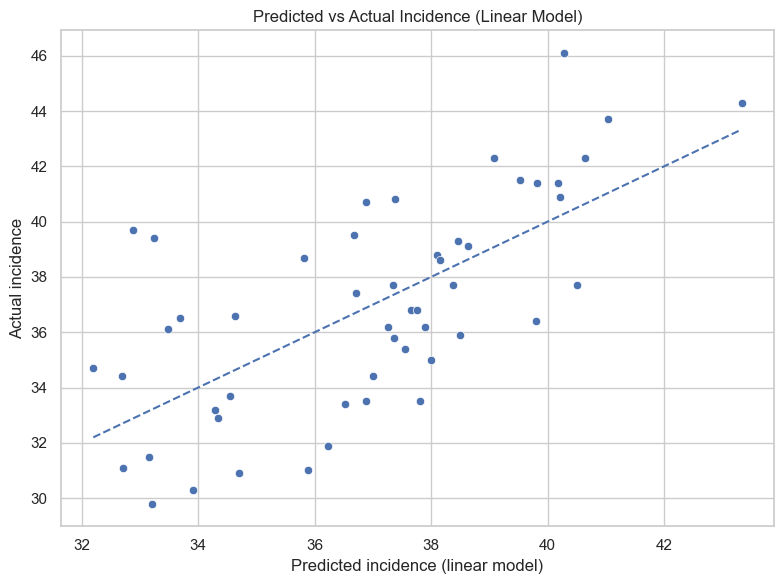

In [7]:
df["predicted_lin"] = lin_model.predict(df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df["predicted_lin"], y=df["incidence_rate_adj"])
plt.plot(
    [df["predicted_lin"].min(), df["predicted_lin"].max()],
    [df["predicted_lin"].min(), df["predicted_lin"].max()],
    linestyle="--"
)

plt.xlabel("Predicted incidence (linear model)")
plt.ylabel("Actual incidence")
plt.title("Predicted vs Actual Incidence (Linear Model)")
plt.tight_layout()
plt.show()


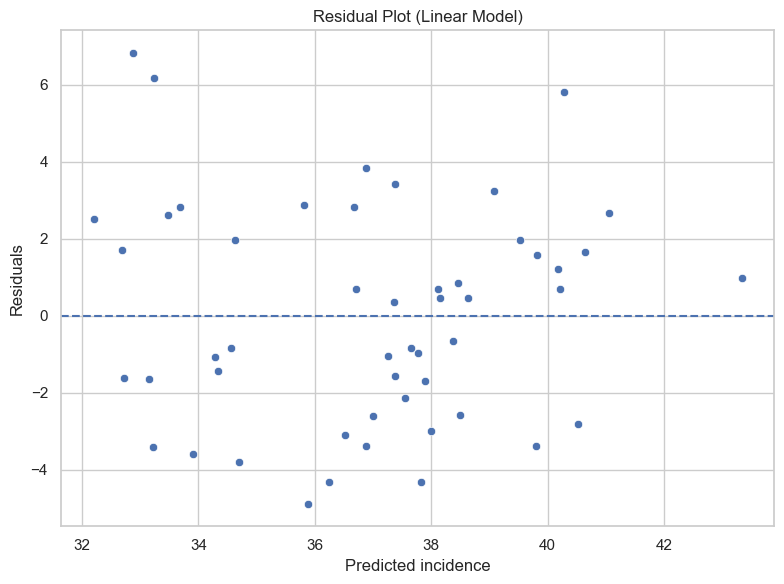

In [8]:
df["residuals_lin"] = df["incidence_rate_adj"] - df["predicted_lin"]

plt.figure(figsize=(8,6))
sns.scatterplot(x=df["predicted_lin"], y=df["residuals_lin"])
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted incidence")
plt.ylabel("Residuals")
plt.title("Residual Plot (Linear Model)")
plt.tight_layout()
plt.show()


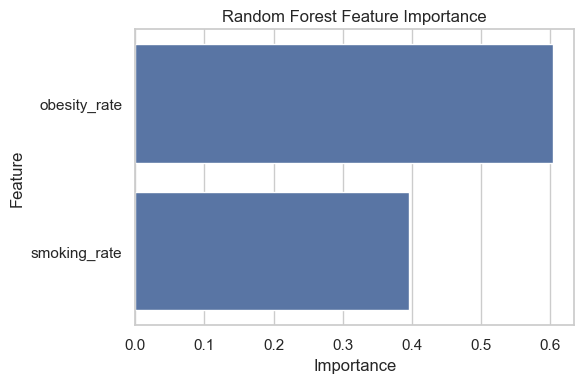

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


In [10]:
top5_inc = df.nlargest(5, "incidence_rate_adj")[
    ["State", "Abbrev", "obesity_rate", "smoking_rate", "incidence_rate_adj"]
].copy()

bottom5_inc = df.nsmallest(5, "incidence_rate_adj")[
    ["State", "Abbrev", "obesity_rate", "smoking_rate", "incidence_rate_adj"]
].copy()

top5_inc, bottom5_inc


(            State Abbrev  obesity_rate  smoking_rate  incidence_rate_adj
 17       Kentucky     KY        34.039        16.626                46.1
 48  West Virginia     WV        38.131        19.950                44.3
 24    Mississippi     MS        36.206        16.385                43.7
 15           Iowa     IA        33.892        13.923                42.3
 18      Louisiana     LA        36.328        15.320                42.3,
             State Abbrev  obesity_rate  smoking_rate  incidence_rate_adj
 21  Massachusetts     MA        23.654         9.736                29.8
 45        Vermont     VT        23.322        11.675                30.3
 39   Rhode Island     RI        26.509        10.549                30.9
 37         Oregon     OR        28.074        11.883                31.0
 5        Colorado     CO        22.312         9.821                31.1)

In [11]:
out_top = BASE / "table_top5_incidence_2022.csv"
out_bottom = BASE / "table_bottom5_incidence_2022.csv"

top5_inc.to_csv(out_top, index=False)
bottom5_inc.to_csv(out_bottom, index=False)

out_top, out_bottom


(WindowsPath('../data/processed/table_top5_incidence_2022.csv'),
 WindowsPath('../data/processed/table_bottom5_incidence_2022.csv'))

In [12]:
summary_data = {
    "model": ["linear", "random_forest"],
    "r2": [lin_results["r2"], rf_r2],
    "r2_adj": [lin_results["r2_adj"], np.nan],
    "coef_obesity": [lin_results["coef_obesity"], np.nan],
    "coef_smoking": [lin_results["coef_smoking"], np.nan],
    "p_obesity": [lin_results["p_obesity"], np.nan],
    "p_smoking": [lin_results["p_smoking"], np.nan],
}

summary_df = pd.DataFrame(summary_data)
summary_df


,model,r2,r2_adj,coef_obesity,coef_smoking,p_obesity,p_smoking
0,linear,0.457774,0.435182,0.398038,0.426282,0.021348,0.084627
1,random_forest,0.893052,NaN,NaN,NaN,NaN,NaN


In [13]:
summary_path = BASE / "model_summary_2022.csv"
summary_df.to_csv(summary_path, index=False)
summary_path


WindowsPath('../data/processed/model_summary_2022.csv')